<a href="https://colab.research.google.com/github/demolakstate/anomaly_detection_sport_video/blob/main/dcgan64_normal_abnormal_modified_generator_loss_cifar10_dataset_no_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Here, we train the discriminator on samples from normal frames ###

In [116]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [117]:
import time, os

In [118]:
print(round(time.time()))

1615434351


In [119]:
time_stamp = round(time.time())

In [120]:
cd /content/gdrive/MyDrive/Anomaly_Detection_Videos/

/content/gdrive/MyDrive/Anomaly_Detection_Videos


In [121]:
os.mkdir(str(time_stamp))


In [122]:
os.chdir(str(time_stamp))

In [123]:
time_stamp

1615434351

In [124]:
#!pip install -q tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf
tf.__version__

'2.4.1'

In [125]:
import tensorflow as tf

In [126]:
from tensorflow.python.client import device_lib

# "GPU" + device_lib.list_local_devices()[-1].physical_device_desc.split(",")[1]

In [127]:
tf.__version__

'2.4.1'

In [128]:
import glob # The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell, although results are returned in arbitrary order. 
import imageio # Imageio is a Python library that provides an easy interface to read and write a wide range of image data, including animated images, volumetric data, and scientific formats. 
%matplotlib inline 
import matplotlib.pyplot as plt 
import tensorflow.keras.layers as layers # Keras layers API
import time
from IPython import display # For displaying image

In [129]:
from tensorflow.keras.models import Model

In [130]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
import PIL
import random

## Load dataset ##

In [131]:
# example of loading the cifar10 dataset
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot
# load the images into memory
(X_train, X_train_label), (X_test, X_test_label) = load_data()
X_train_abnormal = []
X_train_normal = []

# plot images from the training dataset
for i in range(len(X_train)):
  if X_train_label[i] == 0:# and len(X_train_abnormal) <= 10: # few abnormal samples
    X_train_abnormal.append(X_train[i])
  elif X_train_label[i] == 1:
    X_train_normal.append(X_train[i])

In [132]:
X_train_normal = np.asarray(X_train_normal)
X_train_abnormal = np.asarray(X_train_abnormal)

In [133]:
len(X_train_normal)

5000

In [134]:
len(X_train_abnormal)

5000

In [135]:
# expand to 3d, e.g. add channels dimension
#abnormal_data = np.expand_dims(X_train_abnormal, axis=-1)
#normal_data = np.expand_dims(X_train_normal, axis=-1)


In [136]:
abnormal_data = X_train_abnormal

In [137]:
train_images = X_train_normal.reshape(X_train_normal.shape[0], 32, 32, 3).astype('float32')
#train_images = (train_images - 127.5) / 127.5

train_images = (train_images) / 255.0


In [138]:
X_train_normal.shape[0]

5000

In [139]:
abnormal_data = abnormal_data.astype('float32')
#normal_data = normal_data.astype('float32')

abnormal_data = abnormal_data / 255.0
#normal_data = normal_data / 255.0

In [140]:
# X_train_normal_np = X_train_normal_np.astype('float32') / 255.
# X_train_abnormal_np = X_train_abnormal_np.astype('float32') / 255.

In [141]:
# path = "/content/gdrive/MyDrive/Anomaly_Detection_Videos/normal_frames/"

In [142]:
# path_abnormal = "/content/gdrive/MyDrive/Anomaly_Detection_Videos/abnormal_frames/"

In [143]:
# def load_image( infilename ) :
#     img = PIL.Image.open( infilename )
#     #img = img.crop([25,65,153,193])
#     #img = img.resize((64,64))
#     img = img.resize((512,512))
#     data = np.asarray( img, dtype="int32" )
#     return data

In [144]:
latent_dim = 128
C = 3
img_width = img_height = 32

In [145]:
def make_encoder_model():
  inputs = layers.Input(shape=(img_width, img_height, C), name="inputs")
  x = inputs

  x = layers.Conv2D(32, (3,3), padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.MaxPool2D((2,2))(x)

  x = layers.Conv2D(32, (3,3), padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.MaxPool2D((2,2))(x)

  print('shape after encoder: ', x.shape)

  x = layers.Flatten()(x)
  units = x.shape[1]
  x = layers.Dense(latent_dim, name="latent")(x)

  return (x, inputs, units)

In [146]:
def make_generator_model(x, units):
  # Building the generator
  x = layers.Dense(units)(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Reshape((8, 8, 32))(x) # reshape to shape after encoder

  x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(alpha=0.2)(x)

  x = layers.Conv2DTranspose(C, (3,3), strides=2, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("sigmoid", name="outputs")(x)

  outputs = x

  return outputs

In [147]:
x, inputs, units = make_encoder_model()

shape after encoder:  (None, 8, 8, 32)


In [148]:
outputs = make_generator_model(x=x, units=units)

In [149]:
encoder_generator_network = Model(inputs=inputs, outputs=outputs)

In [150]:
print(x.shape)

(None, 128)


In [151]:
abnormal_data.shape

(5000, 32, 32, 3)

In [152]:
#abnormal_images = np.array(os.listdir(path_abnormal))
np.random.shuffle(abnormal_data)
BUFFER_SIZE = len(X_train_abnormal) #200000 # number of images in training i think
BATCH_SIZE = 1#500 # This is just the standard number for batch size. Google for more info
# shuffle and batch the data
np.random.shuffle(abnormal_data)
abnormal_data = np.split(abnormal_data[:BUFFER_SIZE],BATCH_SIZE)

In [153]:
# #abnormal_images = np.array(os.listdir(path_abnormal))
# np.random.shuffle(normal_data)
# BUFFER_SIZE = 5#200000 # number of images in training i think
# BATCH_SIZE = 1#500 # This is just the standard number for batch size. Google for more info
# # shuffle and batch the data
# np.random.shuffle(normal_data)
# #normal_data = np.split(normal_data[:BUFFER_SIZE],BATCH_SIZE)

In [154]:
train_normal_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(54077).batch(64)

In [155]:
#len(abnormal_data[0][1])

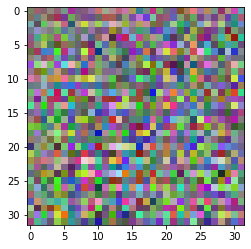

In [156]:
#generator = make_generator_model()

#noise = tf.random.normal([1, img_width,img_height, 1]) # shape is 1, 100
generated_image = encoder_generator_network(abnormal_data, training = True)
#plt.imshow(generated_image[0], interpolation="nearest" )
plt.imshow(generated_image[0])

In [157]:
len(generated_image)

5000

In [158]:
IMG_SIZE = (32, 32)

In [159]:
IMG_SHAPE = IMG_SIZE + (3,)

In [160]:
# base_model = tf.keras.applications.ResNet101(input_shape=IMG_SHAPE,
#                                             include_top=False,
#                                             weights='imagenet')

In [161]:
#base_model.trainable = True

In [162]:
#base_model.summary()

In [163]:
# Let's take a look to see how many layers are in the base model
# print("Number of layers in the base model: ", len(base_model.layers))

# # Fine-tune from this layer onwards
# fine_tune_at = 342

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable =  False

In [164]:
prediction_layer = tf.keras.layers.Dense(1)

In [165]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)             

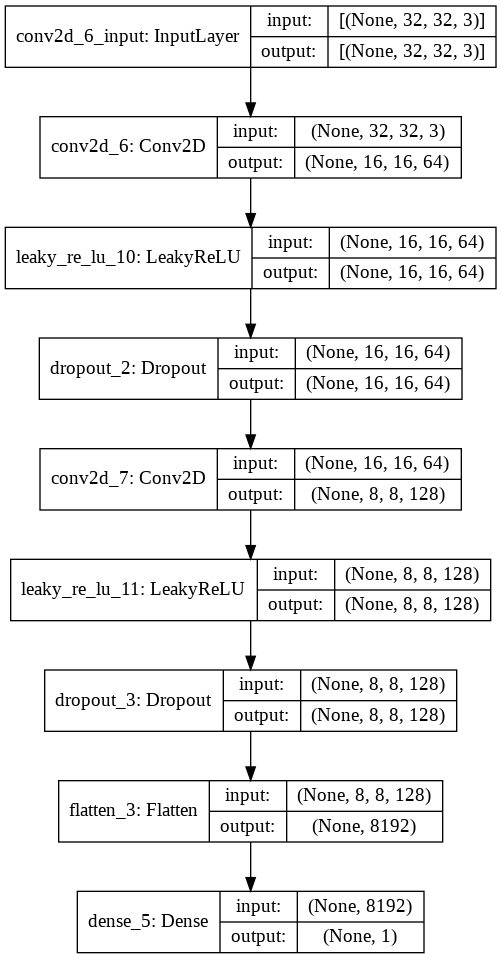

In [166]:
# example of defining the discriminator model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model


# def define_discriminator():
#   inputs = tf.keras.Input(shape=(32, 32, 3))
#   #x = data_augmentation(inputs)
#   #x = preprocess_input(x)
#   x = base_model(inputs, training=False)
#   x = global_average_layer(x)
#   x = tf.keras.layers.Dropout(0.2)(x)
#   outputs = prediction_layer(x)
#   model = tf.keras.Model(inputs, outputs)

#   return model


 
# define the standalone discriminator model
def define_discriminator_2(in_shape=(img_width, img_height, C)):
 model = Sequential()
 model.add(Conv2D(64, (5,5), strides=(2, 2), padding='same', input_shape=in_shape))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Dropout(0.4))
 model.add(Conv2D(128, (5,5), strides=(2, 2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Dropout(0.4))
 model.add(Flatten())
 model.add(Dense(1, activation='sigmoid'))
 # compile model
 #opt = Adam(lr=0.0002, beta_1=0.5)
 #model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
 return model
 
# define discriminator model
discriminator = define_discriminator_2()
# summarize the model
discriminator.summary()
# plot the model
plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [167]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor(
[[0.5054195 ]
 [0.49840057]
 [0.508574  ]
 ...
 [0.5028715 ]
 [0.5132682 ]
 [0.49743485]], shape=(5000, 1), dtype=float32)


In [168]:
len(decision)

5000

## Testing Abnormal data with discriminator ##

In [169]:
abn_data = np.expand_dims(abnormal_data[0][6], axis=0)

In [170]:
decision = discriminator(abn_data)
print(decision) # discriminator decision should be close to 0

tf.Tensor([[0.4961205]], shape=(1, 1), dtype=float32)


In [171]:
type(abn_data)

numpy.ndarray

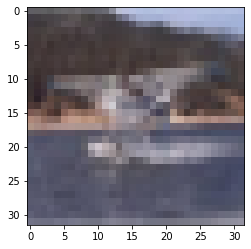

In [172]:
plt.imshow(tf.squeeze(abn_data))

In [173]:
train_images[0].shape

(32, 32, 3)

## Testing Normal data with discriminator ##

In [174]:
nor_data = np.expand_dims(train_images[2510], axis=0)

In [175]:
decision = discriminator(nor_data)
print(decision) # discriminator decision should be close to 1

tf.Tensor([[0.49640247]], shape=(1, 1), dtype=float32)


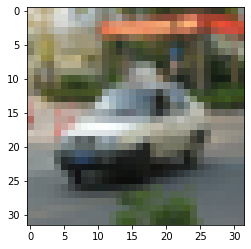

In [176]:
plt.imshow(tf.squeeze(nor_data))

In [177]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

"""
Discriminator Loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predicitions on real images to an array of 1s
and the dicriminator's predicitons on fake (generated) images to an array of 0s.
"""
@tf.function
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

  #abnormal_loss = cross_entropy(tf.zeros_like(abnormal_output), abnormal_output)

  #total_loss = real_loss + fake_loss + abnormal_loss
  total_loss = real_loss + fake_loss
  
  return total_loss

"""
Generator Loss

The generator's loss quantifies how well it was able to trick the discrimator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1).
Here, we will compare the discriminators decisions on the generated images to an array of 1s.
"""
@tf.function
def generator_loss(fake_output):
  # pick abnormal image at random for optimization
  i = random.randint(0, len(abnormal_data))
  print(f'i = {i}')

  loss_1 = cross_entropy(tf.ones_like(fake_output), fake_output)
  #loss_2 = cross_entropy(tf.ones_like(abnormal_data[0][i]), abnormal_data[0][i])
  #loss_2 = cross_entropy(tf.ones_like(generated_images[i]), abnormal_data[0][i])
  #loss_2 = cross_entropy(tf.zeros_like(abnormal_output), abnormal_output)
  total_loss = loss_1
  return total_loss

"""
The discriminator and the generator optimizers are different since we will train two networks separately.
The Adam optimization algorithm is an extension to stochastic gradient descent.
Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training.
A learning rate is maintained for each network weight (parameter) and separately adapted as learning unfolds.

"""
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [178]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = encoder_generator_network,
                                 discriminator = discriminator)

In [179]:
checkpoint_prefix

'./training_checkpoints/ckpt'

In [180]:
# We will reuse this seed overtime (so it's easier) to visualize progress in the animated GIF
#tf.random.set_seed(1234)
noise_dim = 100
num_examples_to_generate = 16
#seed = tf.random.normal([num_examples_to_generate, noise_dim], seed=1)

In [181]:
EPOCHS = 5

In [182]:
"""
The training loop begins with generator receiving a random seed as input. 
That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). 
The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.
"""

# Notice the use of tf.function
# This annotation causes the function to be "compiled"
def train_step(images):
    #noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    # take the image links and return a cropped image
    # new_images = []
    # for file_name in images:
    #     #new_pic = load_image( path + file_name)
    #     #new_images.append(new_pic)
    #     new_images.append(file_name)
    
    # images = np.array(new_images)
    #images = images.reshape(images.shape[0], img_width, img_height, C).astype('float32') # puts each number in its own numpy array so instead of [1,2,3] gonna be [[1], [2], [3]]
    #images = (images) / 255 # normalize to [0,1]
    


    """
GradientTape() Records operations for automatic differentiation. Operations are recorded if 
they are executed within this context manager and at least one of their inputs is being "watched".
    """
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = encoder_generator_network(abnormal_data, training=True)

      real_output = discriminator(images, training=True) # images constist of only normal samples
      #abnormal_output = discriminator(abnormal_data, training=True) # abnormal_data constist of only abnormal samples
      fake_output = discriminator(generated_images, training=True)

      #gen_loss = generator_loss(generated_images=generated_images, fake_output=fake_output)
      gen_loss = generator_loss(fake_output=fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, encoder_generator_network.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, encoder_generator_network.trainable_variables)) # The zip() function returns an iterator of tuples based on the iterable object.
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    images = None

In [183]:
# ended at 20 epocsh

In [184]:
#@tf.function
def train(dataset, epochs):  
  tf.print("Starting man!")
  for epoch in range(epochs):
    start = time.time()
    tf.print("Starting Epoch:", epoch)
    batch_count = 1
    for image_batch in dataset:
      #tf.print("Batch:", batch_count)
      train_step(image_batch)
      #print("Batch:", batch_count, "Complete")
      batch_count += 1
    

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(encoder_generator_network,
                             epoch + 1,
                             abnormal_data)
    
    tf.print("Epoch:", epoch, "finished")
    tf.print()
    
    # Save the model every epochs
    #checkpoint.save(file_prefix = checkpoint_prefix)
    
    tf.print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    if epoch % EPOCHS == 0:
       checkpoint.save(file_prefix = checkpoint_prefix)  
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(encoder_generator_network,
                           epochs,
                           abnormal_data)

In [185]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False. 
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(abnormal_data, training=False).numpy()

  fig = plt.figure(figsize=(150,150))
  print(f'No of predictions: {predictions.shape[0]}')

  #plt.imshow(tf.squeeze(predictions[0]), cmap='gray')
  
  for i in range(9):
      plt.subplot(3, 3, i+1)
      plt.imshow(tf.squeeze(predictions[i]))
      #plt.axis('off')
      if epoch % EPOCHS == 0:      
         plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [186]:
from IPython.display import Image
#Image(filename='image_at_epoch_0060.png') 

In [187]:
type(train_normal_dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [188]:
%%time
train(train_normal_dataset, EPOCHS)

No of predictions: 5000


CPU times: user 7min, sys: 39.8 s, total: 7min 40s
Wall time: 9min 24s


In [189]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [190]:
!ls ../

1615326516  1615434351		      image_at_epoch_2000.png
1615332968  abnormal_frames	      image_at_epoch_3000.png
1615339238  disc_model		      image_at_epoch_4000.png
1615341768  discriminator.h5	      image_at_epoch_5000.png
1615390640  discriminator_plot.png    image_at_epoch_6000.png
1615418536  encoder_generator.h5      image_at_epoch_7000.png
1615420816  gen_model		      image_at_epoch_8000.png
1615425903  image_at_epoch_0002.png   image_at_epoch_9000.png
1615427670  image_at_epoch_10000.png  normal_frames
1615433020  image_at_epoch_1000.png   training_checkpoints


## Inferencing Discriminator on X_test ##

In [191]:
X_test_abnormal = []
X_test_normal = []

# plot images from the training dataset
for i in range(len(X_test)):
  if X_test_label[i] == 0: # few abnormal samples
    X_test_abnormal.append(X_test[i])
  elif X_test_label[i] == 1:
    X_test_normal.append(X_test[i])

## Discriminator score on abnormal images ##

In [192]:
# expand to 3d, e.g. add channels dimension
abnormal_data_test = np.expand_dims(X_test_abnormal, axis=0)

In [193]:
abnormal_data_test = abnormal_data_test.astype('float32')
abnormal_data_test = abnormal_data_test / 255.0

In [194]:
#abnormal_images = np.array(os.listdir(path_abnormal))
np.random.shuffle(abnormal_data_test)
BUFFER_SIZE = len(X_test_abnormal) #200000 # number of images in training i think
BATCH_SIZE = 1#500 # This is just the standard number for batch size. Google for more info
# shuffle and batch the data
np.random.shuffle(abnormal_data_test)
abnormal_data_test = np.split(abnormal_data_test[:BUFFER_SIZE],BATCH_SIZE)

In [195]:
predictions_abnormal_test = []

for index, data in enumerate(abnormal_data_test[0]):
  #abn_data_2 = np.expand_dims(abnormal_data_test[0][index], axis=0)
  abn_data_2 = abnormal_data_test[0][index]
  predictions_abnormal_test.append(discriminator(abn_data_2))
  #print(discriminator(abn_data_2))

In [196]:
len(predictions_abnormal_test[0])

1000

In [222]:
count_test_abnormal = 0

for ind, _ in enumerate(predictions_abnormal_test[0]):
  if (tf.keras.backend.get_value(predictions_abnormal_test[0][ind])) >= 0.1: # setting a threshold of 0.9
    count_test_abnormal += 1
print('count: ', count_test_abnormal)

count:  233


In [223]:
print(f'{count_test_abnormal} abnormal missed' )

233 abnormal missed


In [199]:
X_test_normal = np.asarray(X_test_normal)

In [200]:
test_normal_images = X_test_normal.reshape(X_test_normal.shape[0], 32, 32, 3).astype('float32')
#train_images = (train_images - 127.5) / 127.5

test_normal_images = (test_normal_images) / 255.0

In [201]:
test_normal_ds = tf.data.Dataset.from_tensor_slices(test_normal_images).shuffle(54077).batch(100000000)

In [202]:
decision_test_normal = []

for index, img in enumerate(test_normal_ds):
  #nor_data_test = np.expand_dims(test_normal_images[int(index)], axis=0)
  #nor_data_test = test_normal_ds

  decision = discriminator(img)
  decision_test_normal.append(decision)
  #print(decision) # discriminator decision should be close to 1

In [203]:
len(decision_test_normal[0])

1000

In [204]:
(tf.keras.backend.get_value(decision_test_normal[0][0]))[0]

0.16553275

In [224]:
count_test_normal = 0

for ind, _ in enumerate(decision_test_normal[0]):
  if (tf.keras.backend.get_value(decision_test_normal[0][ind]))[0] >= 0.1: # setting a threshold of 0.9
    #print(decision_test_normal[ind])
    count_test_normal += 1
print('count: ', count_test_normal)

count:  633


In [225]:
print(f'{len(decision_test_normal[0]) - count_test_normal} normal missed' )

367 normal missed


## Save models ##

In [207]:
encoder_generator_network.save('encoder_generator.h5')

In [208]:
discriminator.save('discriminator.h5')

In [209]:
----

SyntaxError: ignored

In [ ]:
fig = plt.figure(figsize=(4,4))
predictions = checkpoint.generator(x_abnormal, training = False).numpy()
for i in range(seed.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i], interpolation="nearest")
    plt.axis('off')
    
plt.show()

In [ ]:
noise = tf.random.normal([1,100]) # shape is 1, 100
random_face = checkpoint.generator(noise, training = False).numpy()[0]
plt.imshow(random_face, interpolation='nearest')
plt.axis("off")
plt.show()

In [ ]:
%ls

In [ ]:
with imageio.get_writer('dcgan.gif', mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
# A hack to display the GIF inside this notebook
os.rename('dcgan.gif', 'dcgan_celebA.gif.png')

In [ ]:
display.Image(filename="dcgan_celebA.gif.png")

In [ ]:
%ls training_checkpoints/

%cp image_at_epoch_0001.png play-with-faces/